## **Part 1: Load Libraries and Dataset**

In [ ]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Load dataset
df = pd.read_csv("loan_approval.csv")
print("✅ Dataset loaded successfully!\n")
print("Columns:", list(df.columns))
print("\nFirst few rows:\n", df.head())



✅ Dataset loaded successfully!

Columns: ['name', 'city', 'income', 'credit_score', 'loan_amount', 'years_employed', 'points', 'loan_approved']

First few rows:
               name              city  income  credit_score  loan_amount  \
0     Allison Hill         East Jill  113810           389        39698   
1     Brandon Hall     New Jamesside   44592           729        15446   
2     Rhonda Smith      Lake Roberto   33278           584        11189   
3  Gabrielle Davis  West Melanieview  127196           344        48823   
4     Valerie Gray         Mariastad   66048           496        47174   

   years_employed  points  loan_approved  
0              27    50.0          False  
1              28    55.0          False  
2              13    45.0          False  
3              29    50.0          False  
4               4    25.0          False  


In [ ]:

df.columns = df.columns.str.strip().str.replace(' ', '_').str.lower()

possible_targets = ['loan_status', 'loan_approval', 'approved', 'approval', 'target', 'status']
target_col = None

for col in df.columns:
    if any(keyword in col for keyword in possible_targets):
        target_col = col
        break

# If not found, ask manually
if target_col is None:
    print("\nAvailable columns:", list(df.columns))
    target_col = input("\nEnter the exact target column name from above: ").strip().lower()

print(f"\n🎯 Target column detected/selected: '{target_col}'")



🎯 Target column detected/selected: 'loan_approved'


## **Part 2: Data Preprocessing**

In [ ]:



df.fillna(df.mode().iloc[0], inplace=True)


label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    if col != target_col:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

X = df.drop(columns=[target_col])
y = df[target_col]

if y.dtype == 'object':
    y = LabelEncoder().fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print("\n✅ Data Preprocessing Completed.")
print(f"Training Samples: {len(X_train)}, Test Samples: {len(X_test)}")


✅ Data Preprocessing Completed.
Training Samples: 1600, Test Samples: 400


## **Part 3: Train and Evaluate Models**


=== Logistic Regression ===
Accuracy : 1.0
Precision: 1.0
Recall   : 1.0
F1-score : 1.0

=== Random Forest ===
Accuracy : 1.0
Precision: 1.0
Recall   : 1.0
F1-score : 1.0


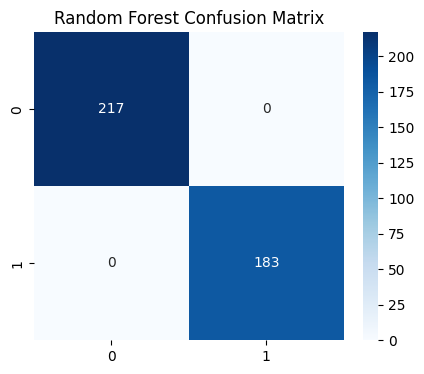

In [ ]:



# Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# Model Evaluation Function
def evaluate_model(name, y_true, y_pred):
    print(f"\n=== {name} ===")
    print("Accuracy :", round(accuracy_score(y_true, y_pred), 4))
    print("Precision:", round(precision_score(y_true, y_pred), 4))
    print("Recall   :", round(recall_score(y_true, y_pred), 4))
    print("F1-score :", round(f1_score(y_true, y_pred), 4))

evaluate_model("Logistic Regression", y_test, lr_pred)
evaluate_model("Random Forest", y_test, rf_pred)

# Confusion Matrix (RF)
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, rf_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.show()

## **`Part 4: Counterfactual Generation using DiCE`**

In [ ]:


!pip install dice-ml --quiet

import dice_ml
from dice_ml import Dice

# Create DiCE Data and Model
d = dice_ml.Data(dataframe=df, continuous_features=X.columns.tolist(), outcome_name=target_col)
m = dice_ml.Model(model=rf_model, backend="sklearn")

exp = Dice(d, m, method="random")

# Pick one negative instance (predicted as 0)
negative_indices = np.where(rf_pred == 0)[0]
if len(negative_indices) == 0:
    raise ValueError("No negative predictions found! Try rerunning with a different model or split.")

test_index = negative_indices[0]
test_instance = pd.DataFrame([X_test[test_index]], columns=X.columns)

# Generate counterfactuals
dice_exp = exp.generate_counterfactuals(test_instance, total_CFs=3, desired_class="opposite")
print("\n=== Counterfactual Examples (showing changed features) ===")
dice_exp.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:00<00:00,  1.82it/s]


=== Counterfactual Examples (showing changed features) ===
Query instance (original outcome : False)


,name,city,income,credit_score,loan_amount,years_employed,points,loan_approved
0,0.0,0.0,1.0,0.0,0.0,0.0,-0.090161,False



Diverse Counterfactual set (new outcome: True)


,name,city,income,credit_score,loan_amount,years_employed,points,loan_approved
0,-0.4847148203376076,0.31242975559785213,0.15153377344134422,0.20918137997725406,0.37956582514079906,0.11328093845653542,47.0,True
1,-0.4847148203376076,348.0,0.15153377344134422,0.20918137997725406,0.37956582514079906,0.11328093845653542,32.4,True
2,-0.4847148203376076,0.31242975559785213,0.15153377344134422,0.20918137997725406,0.37956582514079906,26.0,94.3,True


## **Part 5: Feature Importance Analysis**


=== Top Influential Features ===
 points            0.632057
credit_score      0.276715
income            0.044958
loan_amount       0.025058
years_employed    0.012681
name              0.004997
city              0.003534
dtype: float64


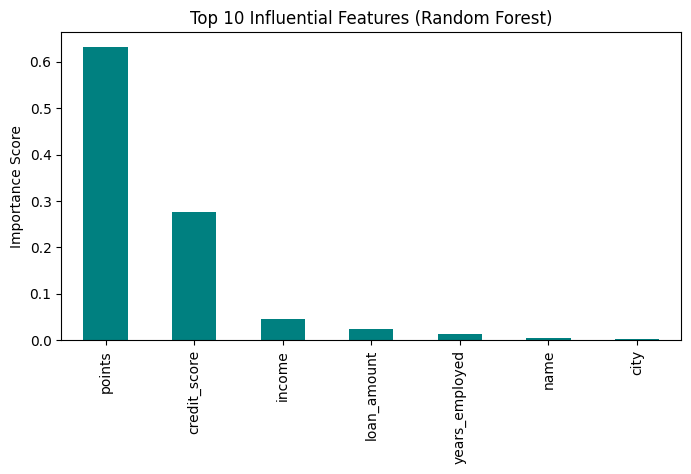

In [ ]:


importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\n=== Top Influential Features ===\n", importances.head(10))

plt.figure(figsize=(8,4))
importances.head(10).plot(kind='bar', color='teal')
plt.title("Top 10 Influential Features (Random Forest)")
plt.ylabel("Importance Score")
plt.show()

## **Part 6: Compare Distance Metrics**

In [ ]:


print("\n🔹 Generating Counterfactuals using Random Method (Euclidean-like behavior)...")
exp_random = Dice(d, m, method="random")

cf_random = exp_random.generate_counterfactuals(
    test_instance,
    total_CFs=3,
    desired_class="opposite"
)

print("\n--- Counterfactuals Generated (Random Method) ---")
cf_random.visualize_as_dataframe(show_only_changes=True)

# Note: The 'random' method does not support distance metric parameters.
# To properly compare Euclidean vs Manhattan, we can use the 'genetic' method.
# This works if your model is a black-box (e.g., sklearn, xgboost).

try:
    print("\n🔹 Generating Counterfactuals using Genetic Algorithm (Euclidean Distance)...")
    exp_genetic_euclidean = Dice(d, m, method="genetic")
    cf_genetic_euclidean = exp_genetic_euclidean.generate_counterfactuals(
        test_instance,
        total_CFs=3,
        desired_class="opposite"
    )
    print("\n--- Counterfactuals (Genetic Method, Euclidean) ---")
    cf_genetic_euclidean.visualize_as_dataframe(show_only_changes=True)
except Exception as e:
    print("\n⚠️ Genetic method not supported for this model type. Showing only random results.")
    print("Error details:", e)



🔹 Generating Counterfactuals using Random Method (Euclidean-like behavior)...


100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


--- Counterfactuals Generated (Random Method) ---
Query instance (original outcome : False)


,name,city,income,credit_score,loan_amount,years_employed,points,loan_approved
0,0.0,0.0,1.0,0.0,0.0,0.0,-0.090161,False



Diverse Counterfactual set (new outcome: True)


,name,city,income,credit_score,loan_amount,years_employed,points,loan_approved
0,-0.4847148203376076,0.31242975559785213,0.15153377344134422,759.0,0.37956582514079906,0.11328093845653542,93.3,True
1,-0.4847148203376076,1773.0,0.15153377344134422,0.20918137997725406,0.37956582514079906,0.11328093845653542,92.4,True
2,-0.4847148203376076,682.0,0.15153377344134422,0.20918137997725406,0.37956582514079906,0.11328093845653542,33.4,True



🔹 Generating Counterfactuals using Genetic Algorithm (Euclidean Distance)...


100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


--- Counterfactuals (Genetic Method, Euclidean) ---
Query instance (original outcome : False)


,name,city,income,credit_score,loan_amount,years_employed,points,loan_approved
0,0.0,0.0,1.0,0.0,0.0,0.0,-0.090161,False



Diverse Counterfactual set (new outcome: True)


,name,city,income,credit_score,loan_amount,years_employed,points,loan_approved
0,-,-,30053.0,300.0,1022.0,-,10.0,True
0,-,-,30053.0,300.0,8630.0,-,10.0,True
0,-,-,30053.0,300.0,6864.0,-,10.0,True
